In [14]:
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
import numpy as np
from src.visualization.dists import plot_pdf

sns.set_theme(style="white", palette="Set2")

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

2023-11-06 11:43:43,784 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-06 11:43:43,786 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-06 11:43:43,788 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

## New Data

In [7]:
gedi_burned_all, gedi_unburned_all = gedi_pipeline.load_stage_4(2)

Text(0.5, 0, 'Time since fire')

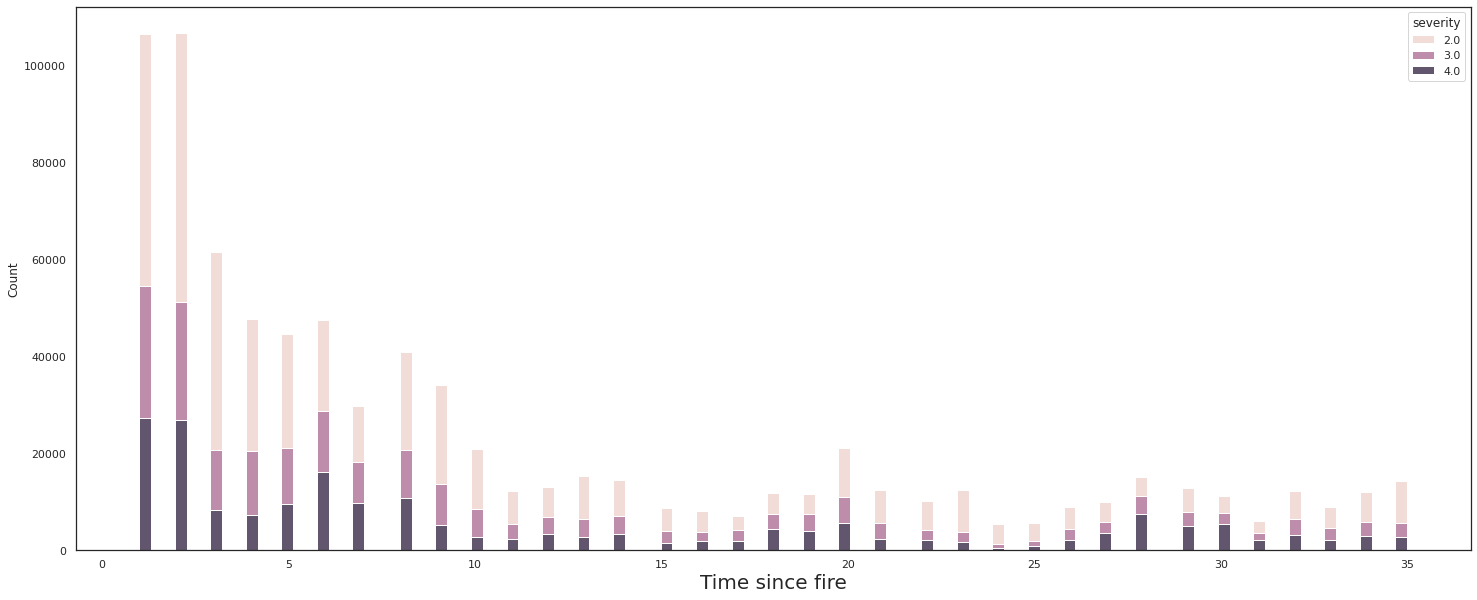

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
df = gedi_burned_all[(gedi_burned_all.time_since_burn > 0) & (gedi_burned_all.time_since_burn < 36) & (gedi_burned_all.severity.isin([2, 3, 4]))]
sns.histplot(df[df.time_since_burn < 36], x="time_since_burn", hue="severity", multiple="stack", ax=ax)
ax.set_xlabel("Time since fire", fontsize=20)
#ax.legend(["High", "Medium", "Low"], fontsize=20)

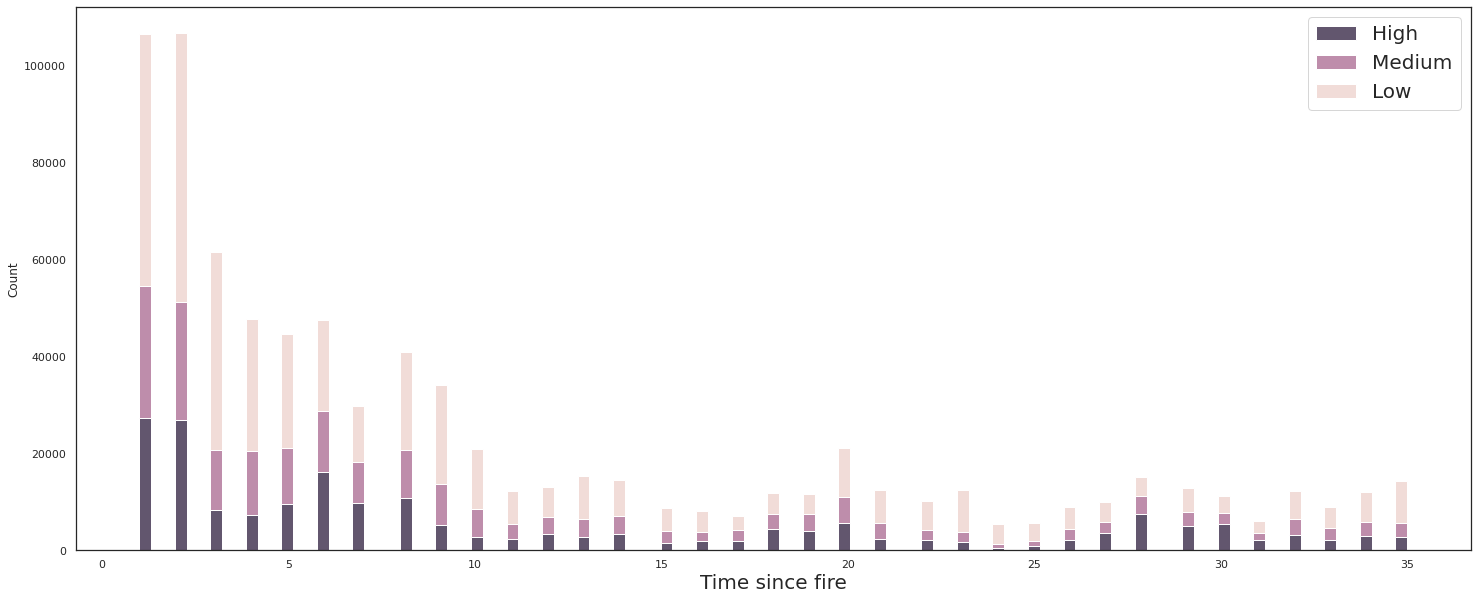

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
df = gedi_burned_all[(gedi_burned_all.time_since_burn > 0) & (gedi_burned_all.time_since_burn < 36) & (gedi_burned_all.severity.isin([2, 3, 4]))]
sns.histplot(df[df.time_since_burn < 36], x="time_since_burn", hue="severity", multiple="stack", ax=ax)
ax.set_xlabel("Time since fire", fontsize=20)
ax.legend(["High", "Medium", "Low"], fontsize=20)

AttributeError: 'GeoDataFrame' object has no attribute 'burn_severity_std'

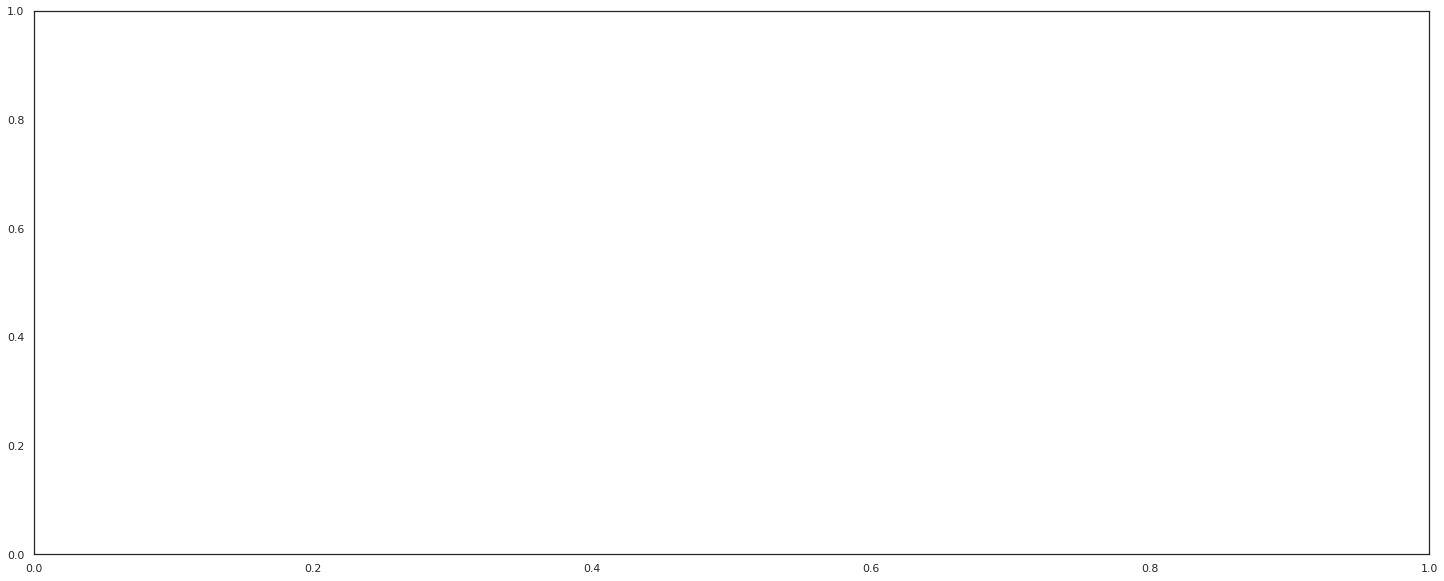

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
df = gedi_burned_all[(gedi_burned_all.time_since_burn > 0) & (gedi_burned_all.time_since_burn < 36) & (gedi_burned_all.severity.isin([2, 3, 4]))]
df = df[df.burn_severity_std == 0]
sns.histplot(df[df.time_since_burn < 36], x="time_since_burn", hue="severity", multiple="stack", ax=ax)
ax.set_xlabel("Time since fire", fontsize=20)
ax.legend(["High", "Medium", "Low"], fontsize=20)

In [2]:
GEDI_PATH = f"{DATA_PATH}/gedi_intermediate"
gedi_burned = load_pickle(f"{GEDI_PATH}/sierras_gedi_combined_stage_11_burned_with_controls_Oct29.pkl")
gedi_unburned = load_pickle(f"{GEDI_PATH}/sierras_gedi_combined_stage_11_unburned_with_controls_Oct29.pkl")

In [3]:
gedi_burned.burn_count.unique()

array([1., 2., 3., 4., 5.])

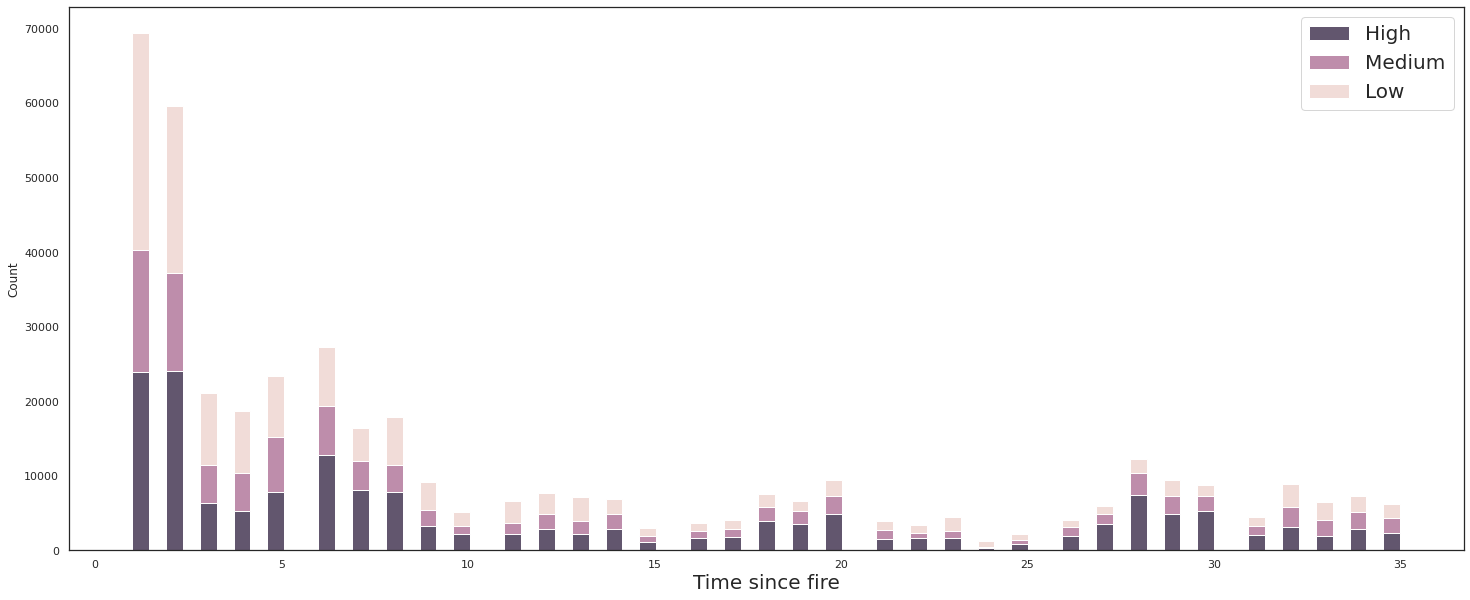

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
df = gedi_burned[gedi_burned.burn_count == 1]
sns.histplot(df[df.time_since_burn < 36], x="time_since_burn", hue="severity", multiple="stack", ax=ax)
ax.set_xlabel("Time since fire", fontsize=20)
ax.legend(["High", "Medium", "Low"], fontsize=20)

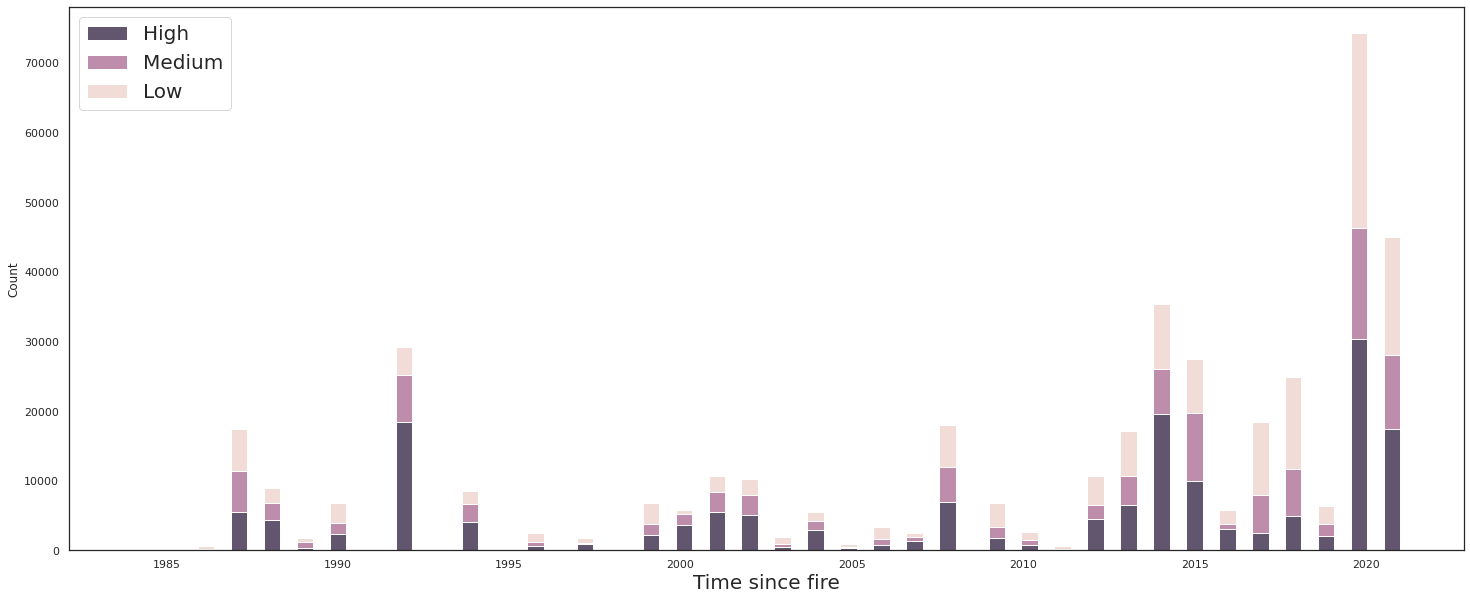

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
df = gedi_burned[gedi_burned.burn_count == 1]
sns.histplot(df[df.time_since_burn < 36], x="burn_year", hue="severity", multiple="stack", ax=ax)
ax.set_xlabel("Time since fire", fontsize=20)
ax.legend(["High", "Medium", "Low"], fontsize=20)

## Work with Old data first, to make sure you have a backup

In [2]:
gedi_recovery_2x2 = load_pickle("/maps/fire-regen/data/gedi_ndvi_time_for_space_jun_28.pkl")

In [43]:
gedi_burned = gedi_recovery_2x2[gedi_recovery_2x2.time_since_burn < 36]

In [44]:
#df = gedi_burned[gedi_burned.slope < 30]
df = gedi_burned

In [45]:
low_10 = df[df.time_since_burn < 24]
low_20 = df[(df.time_since_burn < 32) & (df.time_since_burn >= 24)]

In [11]:
palette = sns.color_palette("Set2")
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

(0.0, 5.0)

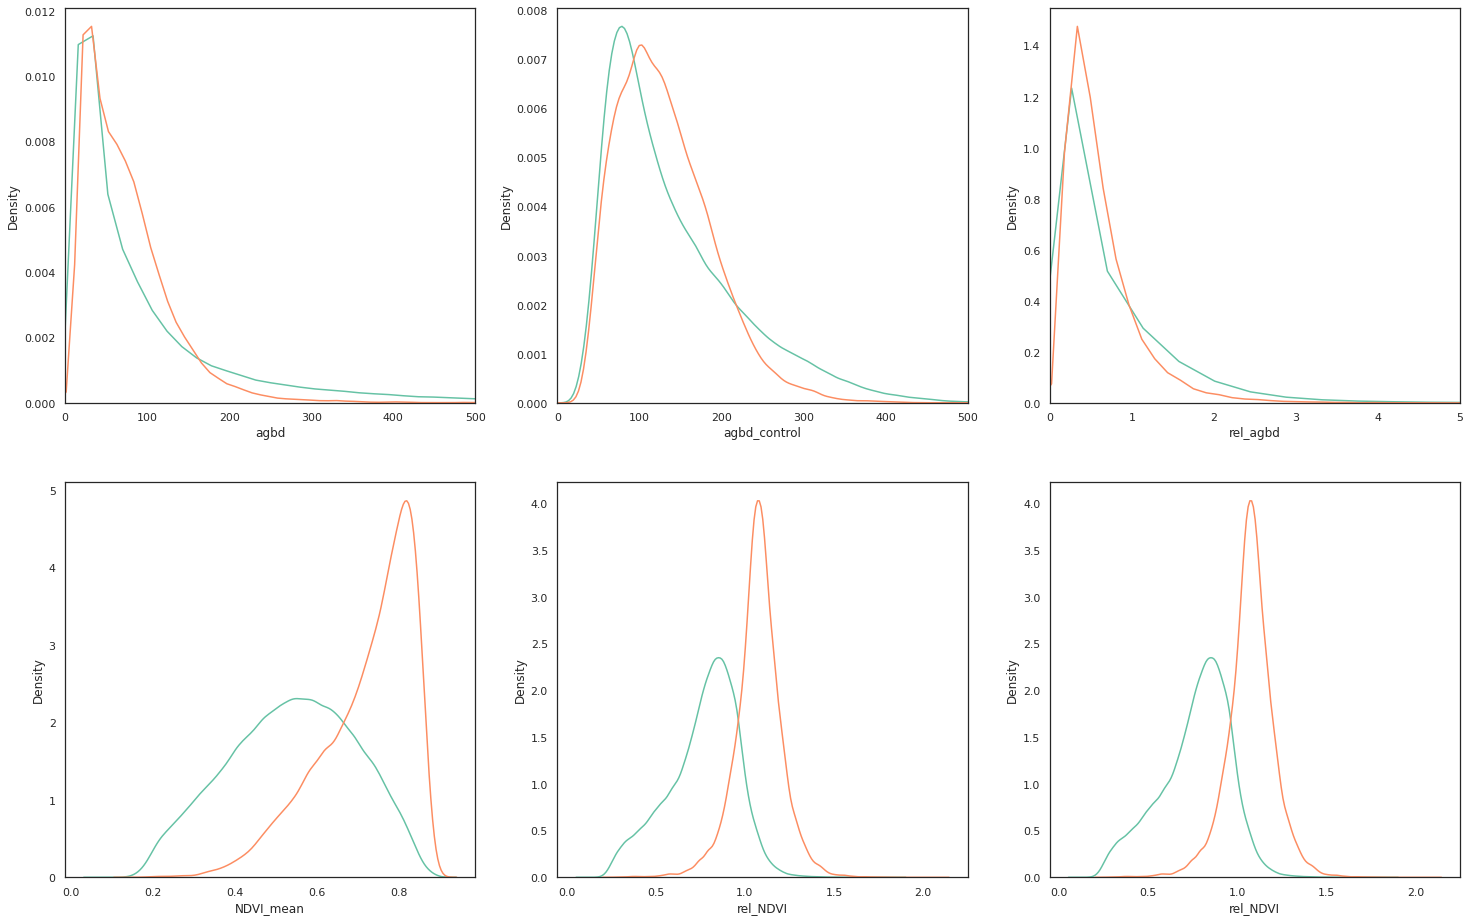

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(25, 16))
sns.kdeplot(low_10, x="agbd", ax=ax[0][0])
sns.kdeplot(low_20, x="agbd", ax=ax[0][0])
sns.kdeplot(low_10, x="agbd_control", ax=ax[0][1])
sns.kdeplot(low_20, x="agbd_control", ax=ax[0][1])
sns.kdeplot(low_10, x="rel_agbd", ax=ax[0][2])
sns.kdeplot(low_20, x="rel_agbd", ax=ax[0][2])
sns.kdeplot(low_10, x="NDVI_mean", ax=ax[1][0])
sns.kdeplot(low_20, x="NDVI_mean", ax=ax[1][0])
sns.kdeplot(low_10, x="rel_NDVI", ax=ax[1][1])
sns.kdeplot(low_20, x="rel_NDVI", ax=ax[1][1])
sns.kdeplot(low_10, x="rel_NDVI", ax=ax[1][2])
sns.kdeplot(low_20, x="rel_NDVI", ax=ax[1][2])
ax[0][0].set_xlim((0, 500))
ax[0][1].set_xlim((0, 500))
ax[0][2].set_xlim((0, 5))

Index(['index', 'shot_number', 'longitude', 'latitude', 'agbd',
       'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se', 'beam_type', 'sensitivity',
       ...
       'NDVI_median', 'ndvi_2020', 'ndvi_2021', 'ndvi_2022', 'rel_NDVI_2019',
       'rel_NDVI_2020', 'rel_NDVI_2021', 'rel_NDVI_2022', 'rel_NDVI',
       'NDVI_mean'],
      dtype='object', length=147)

Text(0.5, 0, 'Latitude')

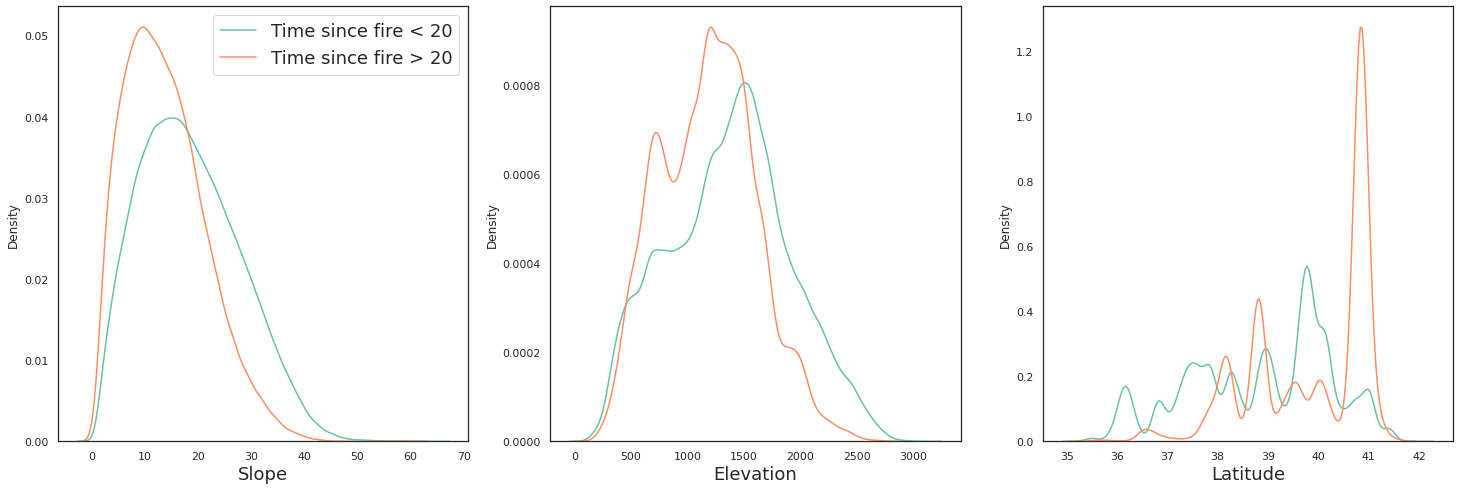

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
sns.kdeplot(low_10, x="slope", ax=ax[0], label="Time since fire < 20")
sns.kdeplot(low_20, x="slope", ax=ax[0], label="Time since fire > 20")
sns.kdeplot(low_10, x="elevation", ax=ax[1], label="Time since fire < 20")
sns.kdeplot(low_20, x="elevation", ax=ax[1], label="Time since fire > 20")
sns.kdeplot(low_10, x="latitude", ax=ax[2], label="Time since fire < 20")
sns.kdeplot(low_20, x="latitude", ax=ax[2], label="Time since fire > 20")
ax[0].legend(fontsize=18)
ax[0].set_xlabel("Slope", fontsize=18)
ax[1].set_xlabel("Elevation", fontsize=18)
ax[2].set_xlabel("Latitude", fontsize=18)

<AxesSubplot: xlabel='time_since_burn', ylabel='slope'>

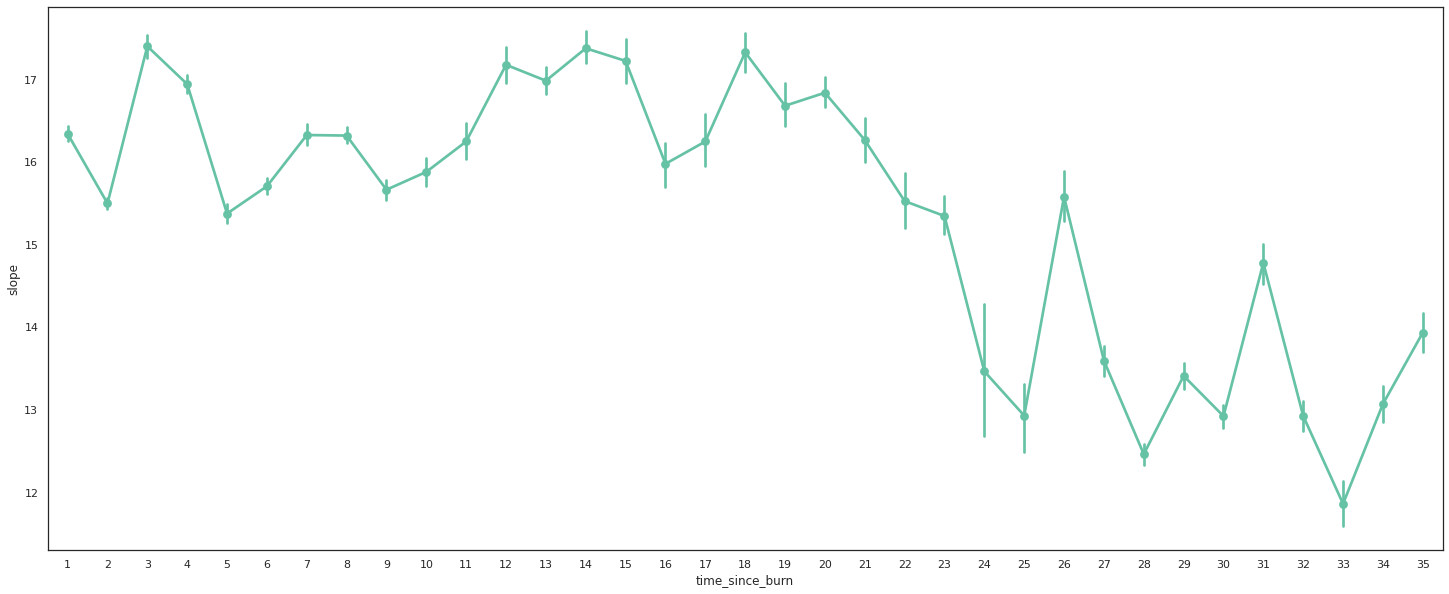

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.pointplot(df[df.time_since_burn < 36], x="time_since_burn", y="slope")

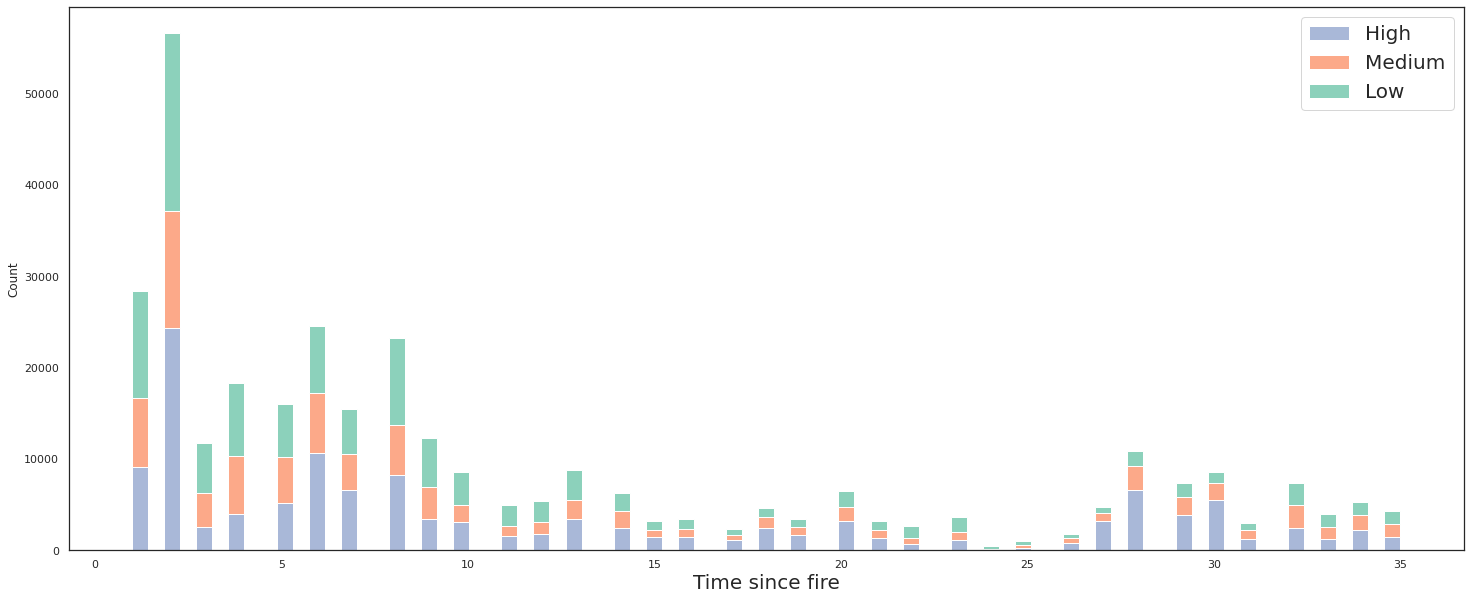

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.histplot(df[df.time_since_burn < 36], x="time_since_burn", hue="severity", multiple="stack", ax=ax)
ax.set_xlabel("Time since fire", fontsize=20)
ax.legend(["High", "Medium", "Low"], fontsize=20)